# Desafió AInwater

Objetivos: caracterizar el funcionamiento de la planta durante esta semana.
* hz totales por ciclo
* crear un label que identifique cual es en que posición del día se encuentra cada ciclo
* comparar el gasto energético entre los diferentes ciclos de cada día
* nivel medio de oxígeno por ciclo (y su distribución)
* nivel medio de oxígeno por ciclo para blower_hz > 0 (y su distribución)

bonus:
* caracterizar el nivel de agua por ciclo
* desarrollar un modelo de clusterización de los ciclos de esta semana

Variables:
* date = fecha de la lectura
* time = hora de la lectura
* do_level = nivel de oxígeno
* h2o_level = nivel de agua
* blower_hz = hz de giro del motor
* cycle_id = label para identificar los ciclos de funcionamiento

Este documento se encuentra divido en 5 partes:

1. [Exploración de datos](#S1)
1. [Análisis Soplador](#S2)
1. [Análisis del Nivel de O<sub>2</sub>](#S3)
1. [Análisis del Nivel de H<sub>2</sub>O](#S4)
1. [Modelo de clusterización de los ciclos de esta semana](#S5)

## 1. Exploración de datos <a id="S1"></a>

In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.insert(0, 'Script')

In [2]:
path_src = "Data/base_test_planta_tupiniquim.csv"
df = pd.read_csv(path_src)
df.head()

Unnamed: 0        date      time  do_level  h2o_level  blower_hz  cycle_id
0        6285  2021-04-14  00:00:28  1.693960   4.931112        0.0         0
1        6287  2021-04-14  00:02:35  1.401860   4.930655        0.0         0
2        6288  2021-04-14  00:05:35  1.134430   4.929771        0.0         0
3        6289  2021-04-14  00:08:35  0.929321   4.930228        0.0         0
4        6290  2021-04-14  00:11:35  0.882311   4.928187        0.0         0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3366 entries, 0 to 3365
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3366 non-null   int64  
 1   date        3366 non-null   object 
 2   time        3366 non-null   object 
 3   do_level    3366 non-null   float64
 4   h2o_level   3366 non-null   float64
 5   blower_hz   3366 non-null   float64
 6   cycle_id    3366 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 184.2+ KB


In [4]:
df.set_index(["date","time"]).duplicated().unique()

array([False])

**Comentarios:**
* De acuerdo a las funciones antoriores, se  observa un nombre de una columna faltante, correspondiente al id del registro. Además, se observa que las columnas "date" y "time" contienen variables del tipo objecto, mientrass que el resto presenta variables enteras (int) o flotantes (float).
* Además, se presentan un total de 3366 entradas, sin presentar datos faltantes, sin presentar registros duplicados.
* Por lo tanto, a traves de la función "read_csvdata" se lee el dataframe especificando el tipo variable al que corresponde cada columna, se crea un label que identifica cual es la posición del día se encuentra cada ciclo con el nombre "datetime", se añaden las columnas año ("year"), mes ("month") y día ("día"), y se renombra la variable "Unnamed: 0" por "registro_id", variable que se define como índice.

In [5]:
from read_data import read_csvdata
type_columns = {
    "date"      : str,
    "time"      : str,
    "do_level"  : float,
    "h2o_level" : float,
    "blower_hz" : float,
    "cycle_id"  : int
}

df = read_csvdata(path_src, type_columns)
df.head()

date      time  do_level  h2o_level  blower_hz  cycle_id  \
registro_id                                                                   
6285         2021-04-14  00:00:28  1.693960   4.931112        0.0         0   
6287         2021-04-14  00:02:35  1.401860   4.930655        0.0         0   
6288         2021-04-14  00:05:35  1.134430   4.929771        0.0         0   
6289         2021-04-14  00:08:35  0.929321   4.930228        0.0         0   
6290         2021-04-14  00:11:35  0.882311   4.928187        0.0         0   

                       datetime  year  month  day  
registro_id                                        
6285        2021-04-14 00:00:28  2021      4   14  
6287        2021-04-14 00:02:35  2021      4   14  
6288        2021-04-14 00:05:35  2021      4   14  
6289        2021-04-14 00:08:35  2021      4   14  
6290        2021-04-14 00:11:35  2021      4   14

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 6285 to 9657
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3366 non-null   object        
 1   time       3366 non-null   object        
 2   do_level   3366 non-null   float64       
 3   h2o_level  3366 non-null   float64       
 4   blower_hz  3366 non-null   float64       
 5   cycle_id   3366 non-null   int32         
 6   datetime   3366 non-null   datetime64[ns]
 7   year       3366 non-null   int64         
 8   month      3366 non-null   int64         
 9   day        3366 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(3), object(2)
memory usage: 276.1+ KB


In [45]:
# Resumen estadistico
def cv_estimator(x):
    return x.std()/x.mean()

print("Coeficiente de variación:")
display(df[["do_level", "h2o_level", "blower_hz", "cycle_id"]].agg(cv_estimator, axis=0))
print("\nResumen Estadístico:")
display(df.loc[:, ~df.columns.isin(["year", "month", "day"])].describe().T)
print("\nCorrelación entre variables")
display(df.loc[:, ~df.columns.isin(["year", "month", "day"])].corr())

Coeficiente de variación:


do_level     1.162882
h2o_level    0.096702
blower_hz    1.630809
cycle_id     0.573379
dtype: float64


Resumen Estadístico:


count       mean        std       min       25%        50%  \
do_level   3366.0   1.360852   1.582510  0.004908  0.057467   0.603368   
h2o_level  3366.0   4.586752   0.443547  3.910520  4.253216   4.397857   
blower_hz  3366.0  12.140579  19.798966  0.000000  0.000000   0.000000   
cycle_id   3366.0  17.574569  10.076893  0.000000  9.000000  18.000000   

                 75%        max  
do_level    2.339908   5.716060  
h2o_level   5.018035   5.412021  
blower_hz  26.440001  50.240002  
cycle_id   26.000000  35.000000


Correlación entre variables


do_level  h2o_level  blower_hz  cycle_id
do_level   1.000000  -0.065409   0.023279  0.022395
h2o_level -0.065409   1.000000  -0.081768  0.063728
blower_hz  0.023279  -0.081768   1.000000  0.030905
cycle_id   0.022395   0.063728   0.030905  1.000000

**Comentarios:**
* En nivel de oxígeno (do_level) presenta mayor variación en relación a su media, con valores registrados que fluctuan desde 0.005 a 5.716 aproximadamente.
* En nivel de agua (h2o_level) presenta menor variación en relación a su media, con valores registrados que fluctuan desde 0.5 a 5.5 aproximadamente.
* Los Hz usados por el soplador (blower_hz) presenta mayor variación en relación a su media, con valores registrados que fluctuan desde 0 a 50.240 aproximadamente. Además, se observa una mediana entorno a 0, debido a que el uso del soplador no es continuo, como se observa en la siguiente figura que representa la serie de tiempo para los Hz del soplador en cada ciclo.
* Finalmente, entre cada una de las variables no existe una linealidad debido a que los valores para el coeficiente de correlación lineal están cerca de 0.

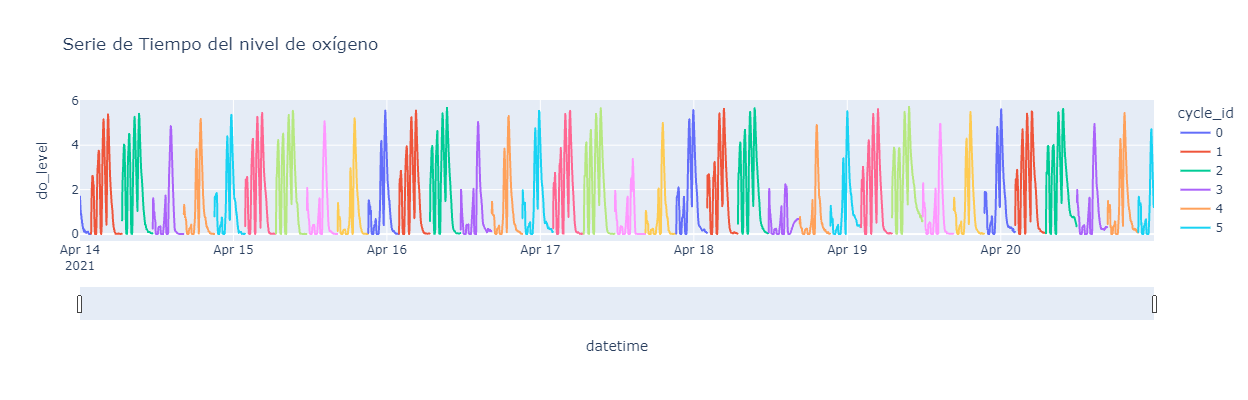

In [8]:
# nivel de oxígeno
import plotly.express as px
fig = px.line(df, x="datetime", y='do_level', color="cycle_id", title='Serie de Tiempo del nivel de oxígeno')

fig.update_layout(height=400)
fig.write_image("Output/images/ST-do_level.png")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

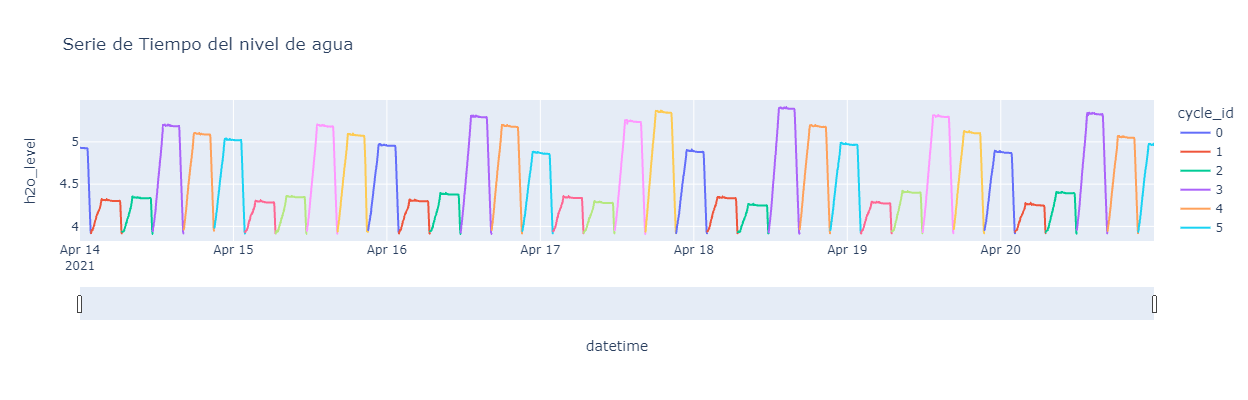

In [9]:
# nivel de agua
fig = px.line(df, x="datetime", y='h2o_level', color="cycle_id", title='Serie de Tiempo del nivel de agua')

fig.update_layout(height=400)
fig.write_image("Output/images/ST-h2o_level.png")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

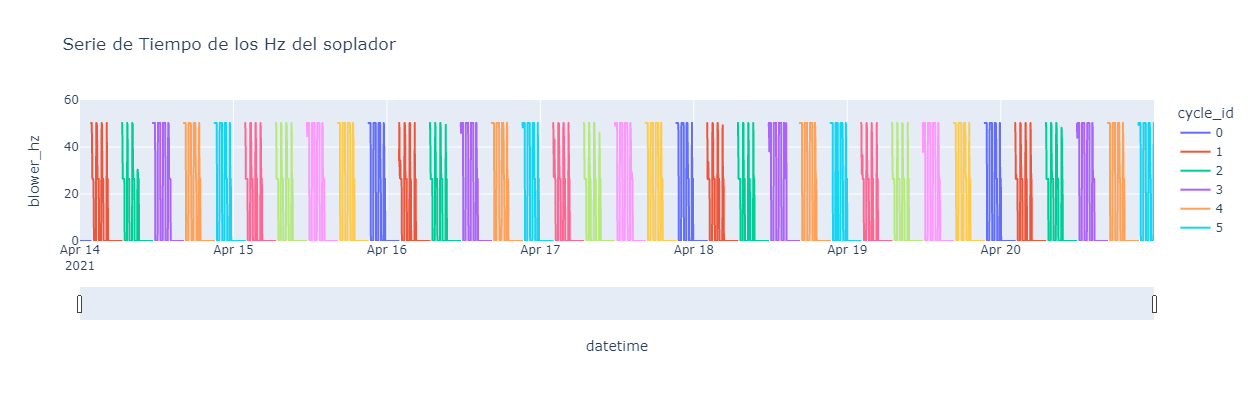

In [10]:
# Hz correspondientes al motor del soplador
fig = px.line(df, x="datetime", y='blower_hz', color="cycle_id", title='Serie de Tiempo de los Hz del soplador')

fig.update_yaxes(range = [0, 60])
fig.update_layout(height=400)
fig.write_image("Output/images/ST-blower_hz.png")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## 2. Análisis Soplador <a id="S2"></a>

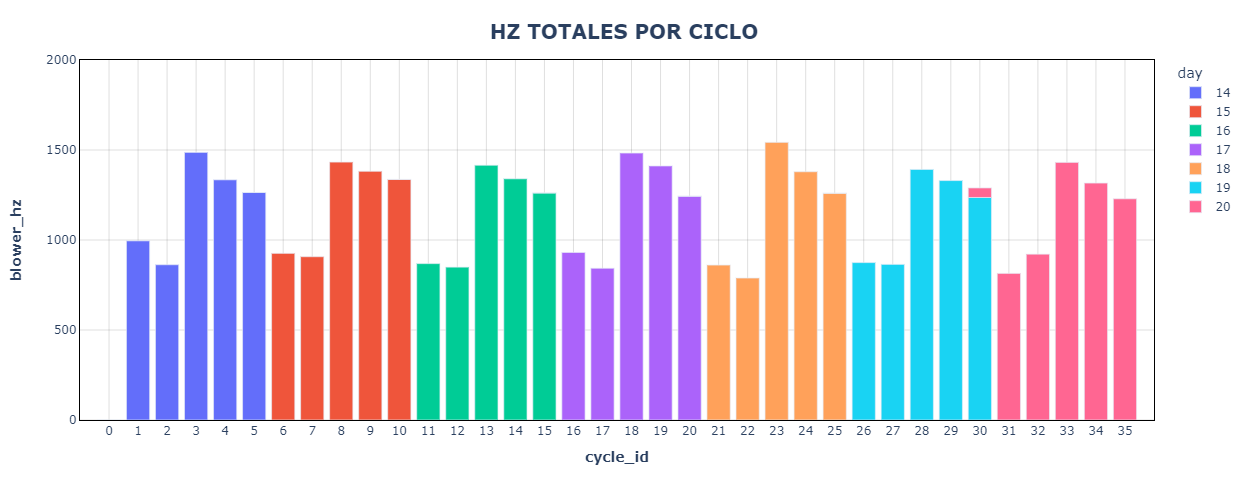

In [11]:
# Hz totales por ciclo
from plot import bar_by_cycle_sum
title = {
    "blower_hz"  : "<b>Hz totales por ciclo</b>",
    "do_level"   : "<b>O<sub>2</sub> total por ciclo</b>",
    "h2o_level"  : "<b>H<sub>2</sub>O total por ciclo</b>"
}
fig = bar_by_cycle_sum(
    df, "blower_hz", title = title, col_color = "day", 
    col_hover_data = ["do_level", "h2o_level", "month", "year"], height = 500, width=1100
)
fig.write_image("Output/images/bar_by_cycle_sum-blower_hz.png")
fig.show()

**Comentarios**
* Complementando a las series de tiempo en la sección de [Exploración de datos](#S1), se observa en la planta de tratamiento un mayor flujo procesado en los ciclos del motor correspondientes a las tardes-noches.
* Lo anterior lleva a un mayor gasto energético por parte del soplador, debido principalmente al nivel de oxígeno necesario para el correcto funciomamiento de la etapa aerobia del proceso productivo.
* Además, en este gráfico se añaden el nivel de oxígeno medio, nivel de agua medio, mes y año.

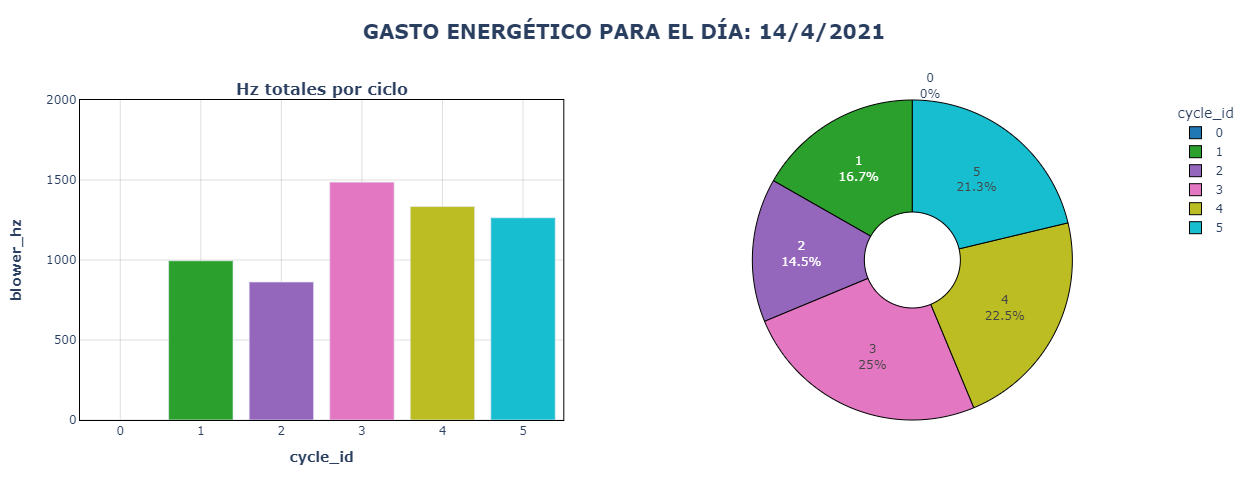

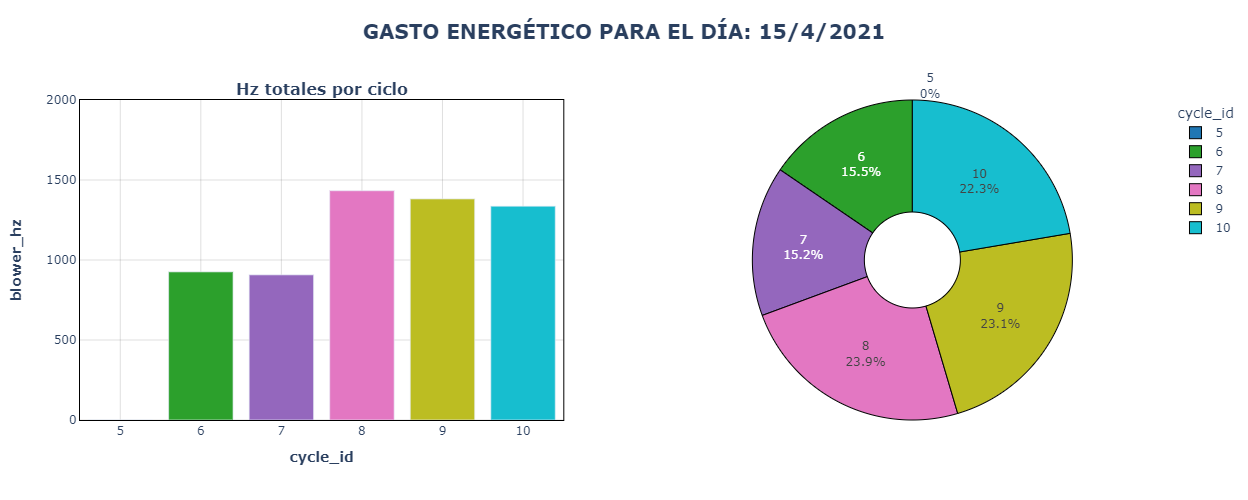

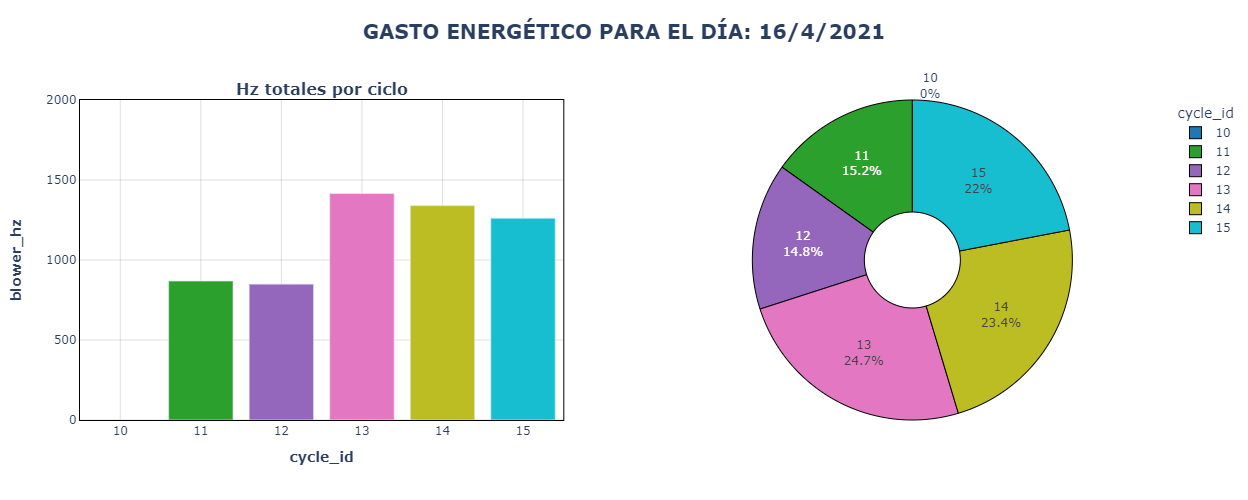

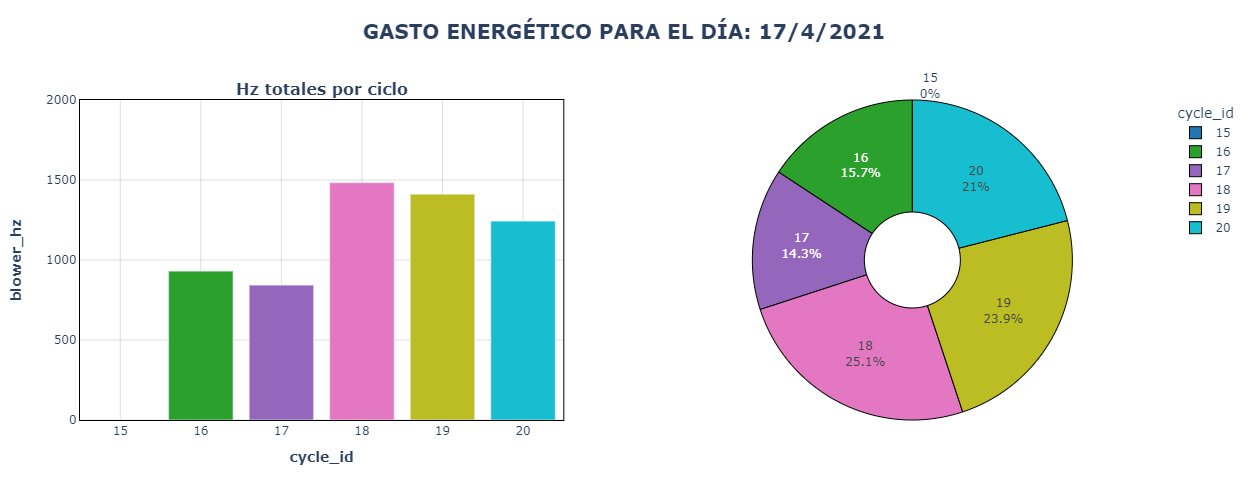

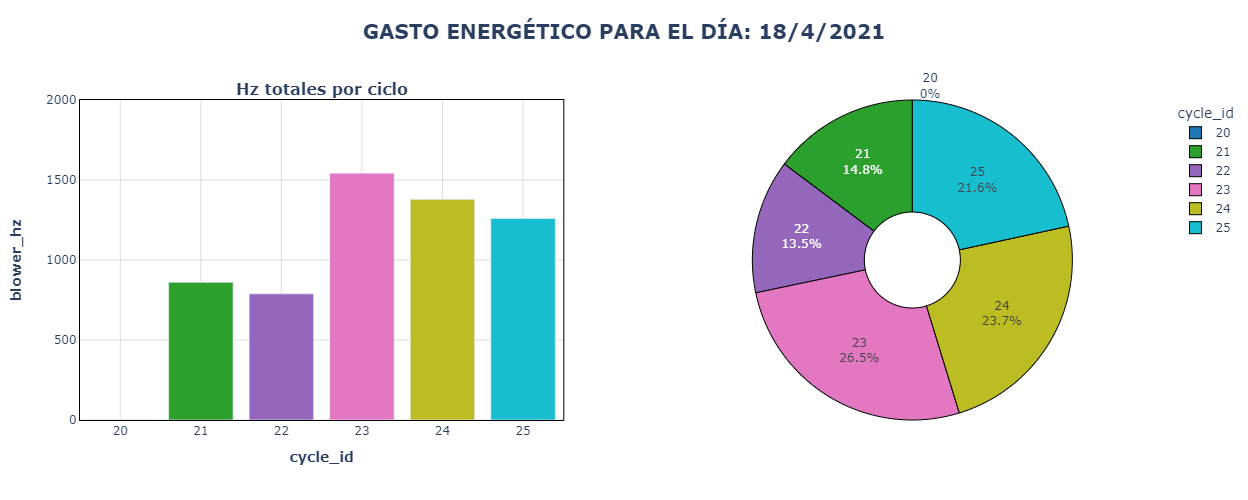

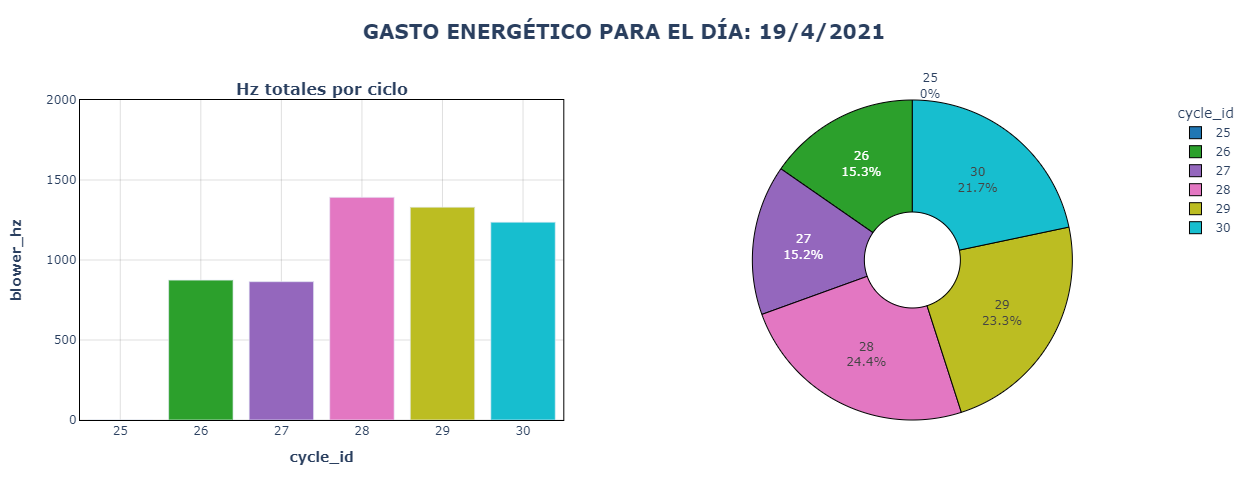

In [12]:
from plot import gastoenergetico_por_dia

for day in df.day.unique():
    fig = gastoenergetico_por_dia(df = df, query="day == "+str(day), col_labels="cycle_id", col_values="blower_hz",
                                  subtitle = "Hz totales por ciclo", col_hover_data = ["do_level", "h2o_level", "month", "year"],
                                  height = 500, width=1000)
    fig.write_image("Output/images/gastoenergetico_por_dia-"+str(day)+"-04-2021.png")
    fig.show()

**Comentarios**
* De acuerdo a cada uno de los gráficos para cada día, los tres últimos ciclos de funcionamiento del motor presentan un consume que varia entre 20% a 25%. Adicionalmente, los ciclos 3, 8, 13, 18, 23, 28 y 33 ubicados en la 4ta posición de izquierda a derecha, presentan el consumo energético máximo.
* El primer ciclo de funcionamiento de cada día presenta un total de 0 Hz a excepción del día 20/04/2021, esto debido a que en ese día el motor del soplador presento su último accionamiento pasada las 24:00 hrs.

## 3. Análisis del Nivel de O<sub>2</sub>. <a id="S3"></a>

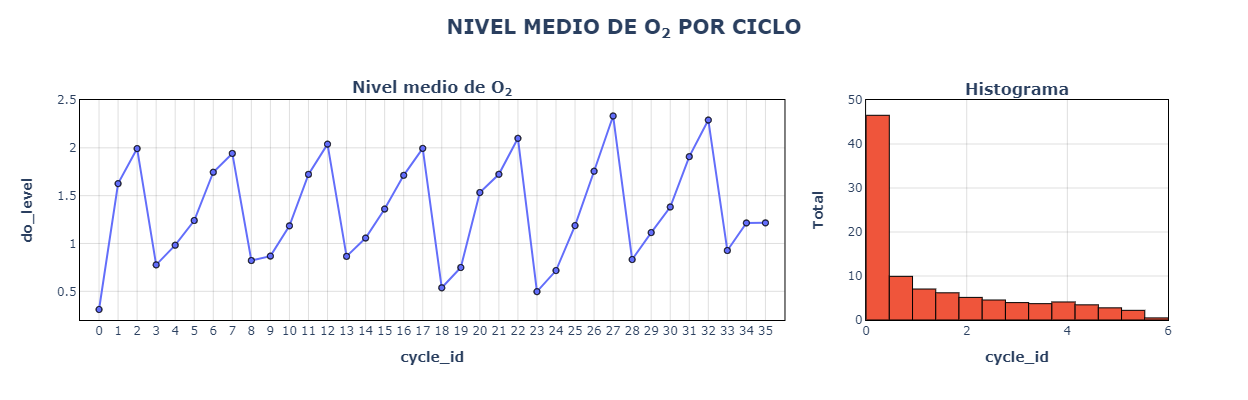

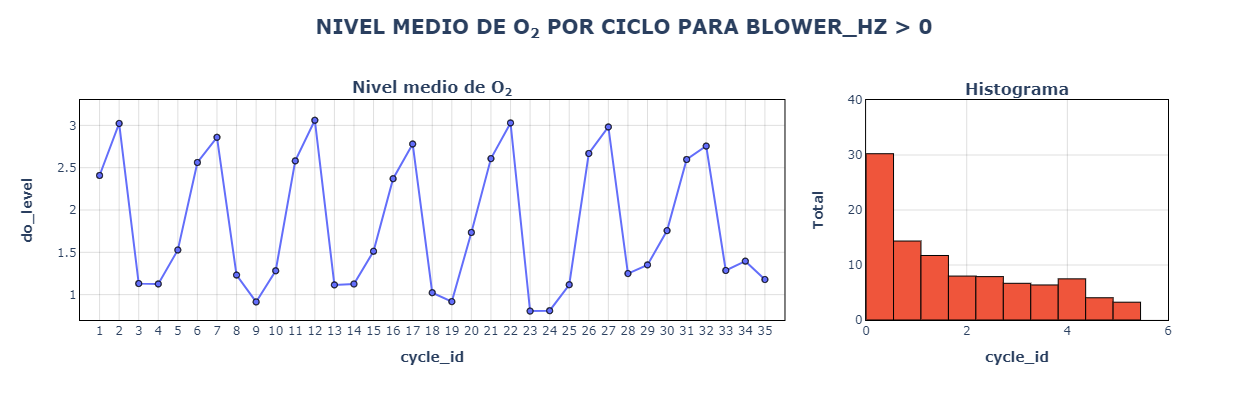

In [46]:
# from plot import bar_by_cycle_mean

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd
import numpy as np
import math
from matplotlib import cm

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

def k_bins(s):
    """
    Función para determinar número de bins en un histograma
    
    s (series.dataframe): Serie de la que se desea enconrar en número de bins para realizar un histograma.
    """
    if s.count() >= 100:
        return np.round(1+ 3.322*np.log10(s.count())).astype(int)
    else:
        return np.round(np.sqrt(s.count())).astype(int)

def bar_by_cycle_mean(df, col_name, title, query_text = None, **kwargs):
    # Agrupar datos por ciclo y obtener el total por ciclo
    if query_text is None:
        title_text = title[col_name].upper()+"<b> por ciclo</b>".upper()
        pass
    else:
        df = df.query(query_text)
        title_text = title[col_name].upper()+"<b> por ciclo para ".upper()+query_text.upper()+"</b>".upper()
        
    grouped_df = df.groupby("cycle_id").mean().reset_index()
    counts, bins = np.histogram(df[col_name], bins=k_bins(df[col_name]), range=(round_down(df[col_name].min()), round_up(df[col_name].max())))
    counts = counts*100/np.sum(counts)
    
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=(title[col_name], "<b>Histograma</b>"),
        column_widths=[0.7, 0.3],
#         shared_yaxes= True,
        horizontal_spacing = 0.075
    )
    # Figura para gráficar nivel medio de cada variable
    fig.add_trace(
        go.Scatter(
            x    = grouped_df["cycle_id"], y = grouped_df[col_name],
            name = title[col_name],
            mode='lines+markers',
            marker=dict(
                line=dict(color='rgba(0, 0, 0, 1.0)', width=1)
            )), row=1, col=1
    )
    # Figura para gráficar el histograma de cada variable
    fig.add_trace(
        go.Histogram(
            x        = df[col_name],
            histnorm = 'percent',
            name   = "<b>Histograma</b>",
            xbins  = dict(
                start = bins[0],
                end   = bins[-1],
                size  = bins[1] - bins[0]
            ),
            marker = dict(
                line = dict(color='rgba(0, 0, 0, 1.0)', width=1),
            )
        ), row=1, col=2
    )
    fig.update_layout(
        # Axis gráfico de barras
        yaxis = dict(
            title = "<b>"+col_name+"</b>", titlefont_size = 14, tickfont_size  = 12, 
            showline = True, linewidth = 1, linecolor = 'black', mirror = True,
            showgrid = True, gridwidth = 0.25, gridcolor = 'rgba(0, 0, 0, 0.5)',
            zeroline = True, zerolinewidth = 0.25, zerolinecolor = 'rgba(0, 0, 0, 0.5)'
        ),
        yaxis_range = [round_down(grouped_df[col_name].min()*0.95, 1), round_up(grouped_df[col_name].max()*1.05, 1)],
        xaxis = dict(
            title = "<b>cycle_id</b>", titlefont_size = 14, tickfont_size  = 12, 
            tickvals = grouped_df["cycle_id"], ticktext = grouped_df["cycle_id"], 
            showline = True, linewidth = 1, linecolor = 'black', mirror = True,
            showgrid = True, gridwidth = 0.25, gridcolor = 'rgba(0, 0, 0, 0.5)',
            zeroline = True, zerolinewidth = 0.25, zerolinecolor = 'rgba(0, 0, 0, 0.5)'
        ),
        xaxis_range = [grouped_df["cycle_id"].min()-1, grouped_df["cycle_id"].max()+1],
        
        # Axis Histograma
        yaxis2 = dict(
            title = "<b>Total</b>", titlefont_size = 14, tickfont_size  = 12, 
            showline = True, linewidth = 1, linecolor = 'black', mirror = True,
            showgrid = True, gridwidth = 0.25, gridcolor = 'rgba(0, 0, 0, 0.5)',
            zeroline = True, zerolinewidth = 0.25, zerolinecolor = 'rgba(0, 0, 0, 0.5)'
                     ),
        yaxis2_range = [0, round_up(np.max(counts)*1.05,-1)],
        xaxis2 = dict(
            title = "<b>cycle_id</b>", titlefont_size = 14, tickfont_size  = 12, 
            showline = True, linewidth = 1, linecolor = 'black', mirror = True,
            showgrid = True, gridwidth = 0.25, gridcolor = 'rgba(0, 0, 0, 0.5)',
            zeroline = True, zerolinewidth = 0.25, zerolinecolor = 'rgba(0, 0, 0, 0.5)' 
                     ),
        xaxis2_range = [bins[0], bins[-1]],
        
        # Tamaño figura
        height     = kwargs["height"],
        width      = kwargs["width"],
        
        # Titulo
        title_text = title_text,
        title_x    = 0.5,
        title_y    = 0.95,
        titlefont_size = 20,
        
        # Legend
        showlegend = False,
        
        # Margenes y color de fondo
        plot_bgcolor = "white",
    )
    
    return fig


title = {
    "blower_hz"  : "<b>Nivel medio de Hz</b>",
    "do_level"   : "<b>Nivel medio de O<sub>2</sub></b>",
    "h2o_level"  : "<b>Nivel medio de H<sub>2</sub>O</b>"
}

# Para todo los datos 
fig = bar_by_cycle_mean(df, "do_level", title = title, height = 400, width=1200)
fig.show()
fig.write_image("Output/images/bar_by_cycle_mean-do_level.png")

# Para blower_hz > 0
fig2 = bar_by_cycle_mean(df, "do_level", title = title, query_text = "blower_hz > 0", height = 400, width=1200)
fig2.show()
fig.write_image("Output/images/bar_by_cycle_mean-do_level-with-query.png")

**Comentarios**
* Recordando de [Exploración de datos](#S1), el nivel de oxígeno (do_level) presenta mayor variación en relación a su media, con valores registrados que fluctuan desde 0.005 a 5.716 aproximadamente, con una media entorno a un valor de 1.36, una desviación estandar de 1,58 y una mediana de 0.6.
* De acuerdo a ambas gráficas, considerando todos los valores de la variable "blower_hz" se observan oscilaciones entre 0.5 a 2.5 respecto el nivel de oxígeno necesario. No obstante, cuando se filtran los resultados cuando el motor del soplador no está funcionando, es decir, no considerar los valores de "blower_hz = 0", el nivel medio de O<sub>2</sub> puede alcanzar valores de 3.
* Referente a los histogramas, ambos presentan una distribución exponencial. En el primer histograma (el que considera todos los valores de la variable "blower_hz") la clase "0 - 0.462" es presenta por sobre 40% de los datos. Por otro lado, cuando se filtran los resultados de la variable "blower_hz", la clase "0 - 0.544" presenta cerca de un 30% de los datos.
* De acuerdo a ambas gráficas, antes de que se produzca un mayor consumo energético en cada uno de los ciclos, es decir, los ciclos 3, 8, 13, 18, 23, 28 y 33, los niveles medios de oxígeno se encuentran por sobre los otros ciclos de funcionamiento de cada día. Este efecto ocurre debido al aumento en el flujo a tratar, y por ende, los niveles de oxígeno en el proceso aerobio disminuyen por una crecida en el volumen a tratar.

## 4. Análisis del Nivel de H<sub>2</sub>O. <a id="S4"></a>

In [48]:
# Para todo los datos 
fig = bar_by_cycle_mean(df, "h2o_level", title = title, height = 500, width=1200)
fig.show()
fig.write_image("Output/images/bar_by_cycle_mean-h2o_level.png")

# Para blower_hz > 0
fig2 = bar_by_cycle_mean(df, "h2o_level", title = title, query_text = "blower_hz > 0", height = 500, width=1200)
fig2.show()
fig.write_image("Output/images/bar_by_cycle_mean-h2o_level-with-query.png")

**Comentarios**
* Recordando de [Exploración de datos](#S1), el nivel de agua (h2o_level) presenta menor variación en relación a su media, con valores registrados que fluctuan desde 0.5 a 5.5 aproximadamente, con una media entorno a un valor de 4.59, una desviación estandar de 0.44 y una mediana de 4.40.
* De acuerdo a ambas gráficas, presentan un nivel de agua entre 4 a 5. No obstante, cuando se filtran los resultados, es decir, "blower_hz > 0", el nivel medio de H<sub>2</sub>O sube levemente.
* Respecto a los histogramas, considerando todos los valores de la variable "blower_hz" se presenta una distribución bimodal. No obstante, cuando se filtran los valores de la variable "blower_hz" esta distribución pasa a ser una distribución normal con un sesgo hacia la derecha.
* De acuerdo a ambas gráficas, cuando se produce un mayor consumo energético en cada uno de los ciclos, es decir, los ciclos 3, 8, 13, 18, 23, 28 y 33, los niveles medios de agua se encuentran por sobre los otros ciclos de funcionamiento de ese día.

## 5. Modelo de clusterización de los ciclos de esta semana. <a id="S5"></a>

In [55]:
# Resumen estadistico
def cv_estimator(x):
    return x.std()/x.mean()

print("Coeficiente de variación:")
display(df[["do_level", "h2o_level", "blower_hz", "cycle_id"]].agg(cv_estimator, axis=0))
print("\nResumen Estadístico:")
display(df.loc[:, ~df.columns.isin(["year", "month", "day"])].describe().T)
print("\nCorrelación entre variables")
display(df.loc[:, ~df.columns.isin(["year", "month", "day"])].corr())

Coeficiente de variación:


do_level     1.162882
h2o_level    0.096702
blower_hz    1.630809
cycle_id     0.573379
dtype: float64


Resumen Estadístico:


count       mean        std       min       25%        50%  \
do_level   3366.0   1.360852   1.582510  0.004908  0.057467   0.603368   
h2o_level  3366.0   4.586752   0.443547  3.910520  4.253216   4.397857   
blower_hz  3366.0  12.140579  19.798966  0.000000  0.000000   0.000000   
cycle_id   3366.0  17.574569  10.076893  0.000000  9.000000  18.000000   

                 75%        max  
do_level    2.339908   5.716060  
h2o_level   5.018035   5.412021  
blower_hz  26.440001  50.240002  
cycle_id   26.000000  35.000000


Correlación entre variables


do_level  h2o_level  blower_hz  cycle_id
do_level   1.000000  -0.065409   0.023279  0.022395
h2o_level -0.065409   1.000000  -0.081768  0.063728
blower_hz  0.023279  -0.081768   1.000000  0.030905
cycle_id   0.022395   0.063728   0.030905  1.000000

Las variables presentan un peso diferente, pues comparando metricas como el promedio o la desviación estandar se observan valores con diferente magnitud, por ello se aplica una escala en función de mínimos y máximos.

In [95]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_PCA2(df, columns, scaler, n_components=2):
    # Filtrar columnas
    X       = df.filter(columns)
    # Ajustar y transformar los datos, incluir valores a un dataframe
    X_trans = pd.DataFrame(scaler.fit_transform(X), columns = columns)
    
    # Análisis de componentes principales para n_componentes
    pca = PCA(n_components=n_components)
    pca = pd.DataFrame(pca.fit_transform(X_trans), columns = ["componente 1", "componente 2"])
    plt.scatter(pca["componente 1"],pca["componente 2"])
    return pca

componente 1  componente 2
0     -0.268547      0.150151
1     -0.270589      0.170162
2     -0.272415      0.188202
3     -0.273920      0.202723
4     -0.274067      0.204755

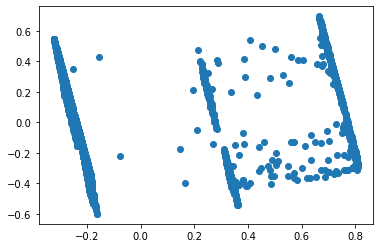

In [86]:
pca = plot_PCA2(df=df, columns=['do_level', 'h2o_level', 'blower_hz'], scaler=MinMaxScaler())
pca.head()

componente 1  componente 2
0     -0.286776     -0.117809
1     -0.288848     -0.106826
2     -0.290702     -0.097021
3     -0.292227     -0.088888
4     -0.292383     -0.088184

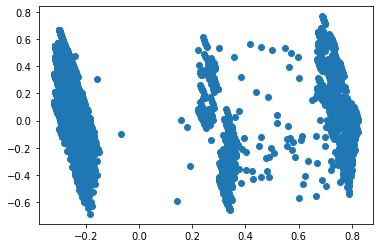

In [87]:
pca = plot_PCA2(df=df, columns=['do_level', 'h2o_level', 'blower_hz', 'cycle_id'], scaler=MinMaxScaler())
pca.head()

In [103]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(df.filter(['do_level', 'h2o_level', 'blower_hz', 'cycle_id']))
X_embedded

array([[ 62.124447 ,  31.77664  ],
       [ 62.199436 ,  31.961014 ],
       [ 62.288868 ,  32.209892 ],
       ...,
       [ -5.3529663, -51.224815 ],
       [  9.416241 ,  16.03524  ],
       [  4.9060483,   8.343057 ]], dtype=float32)

Modelos de clustering a probar:

* K - Means
* DBSCAN
* 

### 5.1 K-means